This script is written for clustering timeseries.
Six collections of timeseries will be clustered in this script
- Annual streamflow 20% threshold
- Daily percentile Semivariograms
- Min daily temperature semivariograms
- Daily percipitaion semivariograms
- Snow water equivalent (SWE) semivariograms
- Medium depth (10-40cm) soil moisture semivariograms

## Importing required libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx
from functools import reduce
from datetime import datetime
import random
import os

## Functions

In [340]:
def cleandailydata(data1):
    
    # Dropping unnessesary columns
    data1.drop(data1.columns.difference(['Date','tmmn_mean','pr_mean','SWE_mean',
                                         'SoilM_10_40cm_mean','weibull_jd_30d_wndw']), axis=1, inplace=True)

    # Delete null values
    data1_clean = data1.dropna(how='any',axis=0)
    data1_clean = data1_clean.reset_index(drop=True)

    # Rename the data
    dailydata = data1_clean
    
    return dailydata


def findevent(dailydata, startdate, enddate, col_name):
    """This function returns the values of user specified feature varaible 
    for a specific drought event
    the inputs are startdate and enddate of the event as string and 
    name of the feature variable as string too
    dailydata is a dataframe of the daily valus of different feature variables"""
    
    df = dailydata
    stdate = datetime.strptime(startdate, '%m/%d/%Y').date()
    eddate = datetime.strptime(enddate, '%m/%d/%Y').date()
    
    # length of the event
    event_len = (eddate - stdate).days
    
    # find the index of the startdate in dailydata df
    df['Date'] = df['Date'].astype('datetime64[ns]')
    df.Date = df.Date.apply(lambda x: x.date())
    idx = df.index[df['Date']== stdate].tolist()
    idx = idx[0]
    
    values = np.zeros((event_len,1)).tolist()
    values = [df[col_name][j] for j  in range(idx, idx+event_len+1)]
    
    return values


def findeventjdp(dailydata, startdate, enddate, col_name):
    """This function returns the values of user specified feature varaible 
    for a specific drought event
    the inputs are startdate and enddate of the event as string and 
    name of the feature variable as string too
    dailydata is a dataframe of the daily valus of different feature variables"""
    
    df = dailydata
    stdate = datetime.strptime(startdate, '%Y-%m-%d').date()
    eddate = datetime.strptime(enddate, '%Y-%m-%d').date()
    
    # length of the event
    event_len = (eddate - stdate).days
    
    # find the index of the startdate in dailydata df
    df['Date'] = df['Date'].astype('datetime64[ns]')
    df.Date = df.Date.apply(lambda x: x.date())
    idxst = df.index[df['Date']== stdate].tolist()
    idxed = df.index[df['Date']== eddate].tolist()
    
    values = [df[col_name][j] for j  in range(idxst[0], idxed[0]+1)]
    
    return values


def adding(n):
    """This function adds all the consecutive numbers
    until n: for example if n=4 then 1+2+3+4=10 is what this 
    function does"""

    return int(n*(n+1)/2)


def rawsv(values):
    """This function returns the squared difference of feature variable values
    with their corresponding lags and takes values from findevent function as inputs"""
    
    n = len(values)-1
    Squared_sv = np.zeros((adding(n),2))
    z = 0
    for i in range(n):
        for j in range(i+1,n+1): 
            Squared_sv[z,0] = int(j-i)
            Squared_sv[z,1] = np.square(values[j]-values[i])
            z = z+1
    Squared_sv = Squared_sv.tolist()
    return Squared_sv


def findraw(var_name,Nd,feature,jdp_data_site):
    """This function returns the raw values array including
    the distances(raw_values[:0]) and semivariance values (raw_values[:1])
    for drought events """
    
    raw_values = []
    if feature == 'sdp':
        for i in range(Nd):
            values = findevent(dailydata,sdp_data_site['start'][i], sdp_data_site['end'][i],var_name)
            raw_values.append(rawsv(values))
    elif feature == 'jdp':
        for i in range(Nd):
            values = findeventjdp(dailydata,(jdp_data_site['start'].to_numpy())[i], (jdp_data_site['end'].to_numpy())[i],
                                  var_name)
            raw_values.append(rawsv(values))
            
    # Flatten the list
    raw_values = np.asarray(reduce(lambda x,y: x+y, raw_values))
    
    return raw_values


def rawsv_plot(x,y,col_name):
    """Plot raw variogram"""
    
    fig, axs = plt.subplots(1, 1,
                            figsize =(15, 7),
                            tight_layout = True)
    axs.scatter(x,y,marker = '.',c = 'black',alpha = 0.05)
    axs.set_title("Raw Semivariogram of " + col_name, fontsize=12)
    axs.set_xlabel('Lag(day)',fontsize=12)
    axs.set_ylabel('Squared Difference of '+col_name, fontsize=12)
    bbox_dict = {'boxstyle': "square", 'fc': (0, 0.2, 1, 0.1), 'ec': (0, 0, 0)}
    label_str = f'N = {x.shape[0]}'
    axs.text(min(x), max(y), label_str, va='top',bbox=bbox_dict)   
    fig.savefig('RawSemivariogram of '+col_name)
    
    
def fixedbin_sv(raw_values, col_name, bin_width):
    """This function returns semivariogram plot
    with an specific number of bins
    it receives data as data frame, col_name as primary variable name
    and bin_width as the length of each bin
    also this function uses raw_sv function to produce needed variables"""
    
    # Build the data as a data frame
    d = {'Lag':raw_values[:,0], 'Sq_dif':raw_values[:,1]}
    df = pd.DataFrame(data=d)
    
    
    rng_days = df['Lag'].max() - df['Lag'].min()
    total_bins = round(rng_days/bin_width)
    
    X = df['Lag']
    Y = df['Sq_dif']
    bins = np.linspace(df['Lag'].min(), df['Lag'].max(), total_bins)
    data_cut = pd.cut(X,bins)   
    
    # Get the values for each bin (mean distance and (semivarice))
    meanvalues = df.groupby(by = data_cut).mean()

    totalN = raw_values.shape[0]
    
    # List of N values for each bin
    N_values = list(df.groupby(by = data_cut).count()['Sq_dif'].to_numpy())
    
    x = meanvalues['Lag'] 
    y = meanvalues['Sq_dif'] 
    # y should not be divided by 2 since direction matters in temporal semivariogram and
    # we calculate the semivariance values only in one direction.
    
    # Plotting the temporal semivariogram
    #fig, axs = plt.subplots(1, 1,
                        #figsize =(13, 7),
                        #tight_layout = True)
    #axs.plot(x,y,c = 'black',alpha = 0.8)
    #axs.set_title("Semivariogram of " + col_name + " with fixed bin width", fontsize=15)
    #axs.set_xlabel('Lag(days)', fontsize=15)
    #axs.set_ylabel('Semivariance of '+col_name, fontsize=15)
    #label_str = f'Number of bins = {total_bins}\nBin width = {bin_width}days\nTotalN = {totalN}'
    #bbox_dict = {'boxstyle': "square", 'fc': (0, 0.2, 1, 0.1), 'ec': (0, 0, 0)}
    #axs.text(x.max(), y.min(), label_str, ma='left', ha='right', bbox=bbox_dict)
    #Q = input('Do you want confidence intervals and N values?[y/n]')
    #if Q == 'y':
    #for i, label in enumerate(N_values):
        #axs.annotate(label, (x[i]+0.5, y[i]+0.25),fontsize=12)
        
    # 95% Confidence Interval
    #up = y + 0.025*y
    #low = y - 0.025*y
    #axs.plot(x,up,label = 'Upper bound',linestyle='--')
    #axs.plot(x,low,label = 'Lower bound',linestyle='--')
    #plt.fill_between(x, up, low, alpha=0.2, label='95% CI')
    
    #axs.legend(loc = 'upper left')
    #fig.savefig('fixedbin_sv of '+col_name)
    
    return meanvalues


def settitle(var_name):
    if var_name == 'weibull_jd_30d_wndw':
        main_title = 'Daily percentiles semivariograms'
    if var_name == 'thresh_20_jd_30d_wndw':
        main_title = 'Annual streamflow 20% threshold'
    if var_name == 'tmmn_mean':
        main_title = 'Min daily temperature semivariograms'
    if var_name == 'pr_mean':
        main_title = 'Daily precipitaion semivariograms'
    if var_name == 'SWE_mean':
        main_title = 'Snow water equivalent (SWE) semivariograms'
    if var_name == 'SoilM_10_40cm_mean':
        main_title = 'Medium depth (10-40cm) soil moisture semivariograms'
        
    return main_title

def TScluster(TimeS_df,n_cluster,method,coordinates,var_name):
    """
    TimeS_df: pandas df of timeseries(No. Timeseries, No. steps(timesteps))
    n_cluster: number of clusters
    method:"dtw"  or  "euclidean"
    coordinates of sites (lat,long)
    """
    # Modify coordinates(delete site without any drought event)
    coordinates = coordinates.loc[coordinates['site'].isin(list(TimeS_df['StaID']))]
    coordinates = coordinates.reset_index(drop=True)
    TimeS_df = TimeS_df.loc[TimeS_df['StaID'].isin(list(coordinates['site']))]
    TimeS_df = TimeS_df.reset_index(drop=True)
     # Build GeoPandas dataframe of coordinates
    # designate coordinate system
    crs = {'init': 'epsg:4269'}
    # zip x and y coordinates into single feature (here as points from sharply.geometry)
    geometry = [Point(xy) for xy in zip(coordinates['long'], coordinates['lat'])]
    # create GeoPandas dataframe
    geo_co = gpd.GeoDataFrame(coordinates,
                              crs = crs,
                              geometry = geometry)
        
    # Recale the data
    if var_name=='thresh_20_jd_30d_wndw':
        data = TimeS_df.iloc[:,1:].to_numpy()
        for i in range(len(data)):
            scaler = MinMaxScaler()
            data[i] = MinMaxScaler().fit_transform(data[i].reshape(-1,1)).reshape(len(data[i]))
    else:
        # Normalize the data by drainage area
        data = TimeS_df.iloc[:,1:].to_numpy()
        #for i in range(len(data)):
            #data[i] = (data[i].reshape(-1,1)/geo_co['DRAIN_SQKM'][i]).reshape(len(data[i]))
    
    # Clustering
    seed = 0
    model = TimeSeriesKMeans(n_clusters=n_cluster, metric=method, max_iter=10,random_state=seed).fit(data)
    
    
    # Row and Column calculation based of number of clusters
    if n_cluster>10:
        print('Number of clusters could not be more than 7')
        return
    elif n_cluster%2 == 0:
        num_rows = int(n_cluster/2)
        num_cols = 2 
    elif n_cluster%3 == 0:
        num_rows = int(n_cluster/3)
        num_cols = 3
    elif n_cluster%5 == 0:
        num_rows = 3
        num_cols = 2
    elif n_cluster%7 == 0:
        num_rows = 4
        num_cols = 2
    
    
    # Plotting clusters
    color = ['b', 'g', 'r','orange','c', 'purple', 'm', 'k','brown','olive','y']
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10,10),constrained_layout=True, frameon=False)
    main_title = settitle(var_name)
    fig.suptitle(main_title, fontsize=20,va='top',ha='center')
    clus_num = 0
    for r in range(num_rows):
        for c in range(num_cols):
            if clus_num >= n_cluster:
                break
            for xx in data[model.labels_ == clus_num]:
                axs[r, c].plot(xx.ravel(), color = color[clus_num] , alpha=0.08)
            axs[r, c].plot(model.cluster_centers_[clus_num].ravel(), color = color[clus_num])
            Nvalue = data[model.labels_ == clus_num].shape[0]
            axs[r,c].set_title('Cluster '+ str(clus_num+1) + ', Nvalue = '+str(Nvalue),fontsize=15 )
            axs[r,c].set_xlabel('Time(days)', fontsize=12)
            if var_name=='thresh_20_jd_30d_wndw':
                axs[r,c].set_ylabel('Rescaled value', fontsize=12)
            else:
                axs[r,c].set_ylabel('Semivariance value', fontsize=12)
            clus_num += 1   
    plt.show()  
    
    # Adding cluster number to our coordinates geopandas dataframe
    geo_temp = geo_co.assign(clus_num=model.labels_)
    
    return geo_temp


def clusterplot(geo_temp,var_name):
    """This function plots gauges based on cluster number color coded
    and returns two figures for HCDN Yes and HCDN No gauges """
    var_title = settitle(var_name)
    # Calculate number of clusters
    n_cluster = geo_temp['clus_num'].max() - geo_temp['clus_num'].min() + 1
    # color list should be the same as color list in TScluster function
    color = ['b', 'g', 'r','orange','c', 'purple', 'm', 'k','brown','olive','y']
    # Creating map of different gages
    # plotting gages on two separate figures 
    f1, ax1 = plt.subplots(figsize=(12,16))
    ax1.set_title(var_title+" with HCDN Yes",fontsize=15,fontweight='bold')
    ax1.set_xlabel('Decimal longitude',fontsize=12)
    ax1.set_ylabel('Decimal latitude',fontsize=12)
    basin.plot(ax=ax1, alpha = 0.5, color='gray', edgecolor="black")
    rivers.plot(ax=ax1,alpha = 0.2)
    # plotting gages
    # Number of Timeseries in each cluster for HCDN Yes
    N1_value = []
    for nc in range(n_cluster):
        geo_temp[(geo_temp['clus_num' ]== nc)&(geo_temp['HCDN.2009' ]== 'yes')].plot(ax=ax1,alpha=1, color=color[nc],
                                                                                    markersize=100,marker='x')
        N1_value.append(geo_temp[(geo_temp['clus_num' ]== nc)&(geo_temp['HCDN.2009' ]== 'yes')].shape[0])
    
    # Adding legend
    h1_1 = [plt.plot([],[], color=color[i], marker="o", ls="")[0] for i in range(n_cluster)]
    leg = plt.legend(handles=h1_1, labels=[str(i+1) for i in range(n_cluster)],
                     bbox_to_anchor=(1.02,1), loc="upper left",
                     title=" Cluster ",fontsize=15,title_fontsize=15)
    ax1.add_artist(leg)
    h1_2 = [plt.plot([],[], color=color[i], marker="x", ls="")[0] for i in range(n_cluster)]
    plt.legend(handles=h1_2,labels=[str(N1_value[i]) for i in range(n_cluster)],
               bbox_to_anchor=(1.02,.8-(n_cluster-4)*.03), loc="upper left",
               title=" N value",fontsize=15,title_fontsize=15)
    
     # Adding basemap
    ctx.add_basemap(ax1, alpha=1,crs='epsg:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.grid()
    
    
    
    #### Plot number 2 with HCDN No ####
    f2, ax2 = plt.subplots(figsize=(12,16))
    ax2.set_title(var_title+" with HCDN No",fontsize=15,fontweight='bold')
    ax2.set_xlabel('Decimal longitude',fontsize=12)
    ax2.set_ylabel('Decimal latitude',fontsize=12)
    basin.plot(ax=ax2, alpha = 0.5, color='gray', edgecolor="black")
    rivers.plot(ax=ax2,alpha = 0.2)
    # plotting gages
    N2_value = []
    for nc in range(n_cluster):
        geo_temp[(geo_temp['clus_num' ]== nc)&(geo_temp['HCDN.2009' ]== 'no')].plot(ax=ax2,alpha=1, color=color[nc],
                                                                                    markersize=100,marker='+')
        N2_value.append(geo_temp[(geo_temp['clus_num' ]== nc)&(geo_temp['HCDN.2009' ]== 'no')].shape[0])
        
    # Adding legend
    h2_1 = [plt.plot([],[], color=color[i], marker="o", ls="")[0] for i in range(n_cluster)]
    leg = plt.legend(handles=h2_1, labels=[str(i+1) for i in range(n_cluster)],
                     bbox_to_anchor=(1.02,1), loc="upper left",
                     title=" Cluster ",fontsize=15,title_fontsize=15)
    ax2.add_artist(leg)
    h2_2 = [plt.plot([],[], color=color[i], marker="+", ls="")[0] for i in range(n_cluster)]
    plt.legend(handles=h2_2,labels=[str(N2_value[i]) for i in range(n_cluster)],
               bbox_to_anchor=(1.02,.8-(n_cluster-4)*.03), loc="upper left",
               title=" N value",fontsize=15,title_fontsize=15)
    
    # Adding basemap
    ctx.add_basemap(ax2, alpha=1,crs='epsg:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.grid()
     

def bxplt(geo_temp,var_name):
    """This function plot the box-plot of drainage areas of each cluster's gauges
    as input it receives geo_temp which is the product of TScluster function
    """
    # Calculate number of clusters
    n_cluster = geo_temp['clus_num'].max() - geo_temp['clus_num'].min() + 1
    
    # Create a list of lists in which each element is the list of drainage area
    # for a cluster
    data = []
    for nc in range(n_cluster):
        drain_list = list(geo_temp[(geo_temp['clus_num' ]== nc)]['DRAIN_SQKM'].values)
        drain_list = [x for x in drain_list if str(x) != 'nan']
        data.append(drain_list)
    
    # Colors should match with color list in TScluster and clusterplot functions
    colors = ['b', 'g', 'r','orange','c', 'purple', 'm', 'k','brown','olive','y']
    
    # Plotting
    fig = plt.figure(figsize =(12, 8))
    ax = fig.add_subplot(111)
    
    # Creating axes instance
    bp = ax.boxplot(data, patch_artist = True,notch ='True', vert = True)
    
    # Set color for boxes so they match cluster's colors
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # changing color and linewidth of
    # whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='#000000', linewidth = 1.5, linestyle =":")
        
    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)
 
    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='black',
                   linewidth = 3)
 
    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='D',
                  color ='#e7298a',
                  alpha = 0.5)
        
    xticks = ['cluster ' + str(i+1) for i in range(n_cluster)]
        
    # x-axis labels
    ax.set_xticklabels(xticks,fontsize=12)
 
    # Adding title
    var_title = settitle(var_name)
    plt.title("Drainage area box plot for clusters of "+var_title,fontsize = 15)
    plt.ylabel("Drainage area (Sqkm)",fontsize = 12)
 
    # Removing top axes and right axes
    # ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
     
    # show plot
    plt.show()
    

def Sv_df(var_name,directory,TS_len):
    """This function create a dataframe such that each row is a timeseries
    and each column is a index of timeseries
    time series are a slice of the semivariogram of the specified variable
    with the length of TS_len"""
    
    input_sites425 = [file for file in os.listdir(directory)]
    
    # create a zeros numpy array
    TimeS_arr425 = np.zeros((len(input_sites425), TS_len+1))
    # Calcaulation of semivariance time series for each site
    for i in range(len(input_sites425)):
        # Reading from directory
        datafile = input_sites425[i]
        df = pd.read_csv(directory+datafile)
        # Site Id extraction
        s = input_sites425[i]
        siteID='SW' + s[7:-4]
        int_siteid = int(s[7:-4])
        # Clean the data
        dailydata = cleandailydata(df)
        # Specify the event data
        sdp_data_site = sdp_data[sdp_data["site"] == siteID]
        jdp_data_site = jdp_data[jdp_data["site"] == siteID]
        jdp_data_site = jdp_data_site[jdp_data_site['start']>dailydata['Date'][0]]
        jdp_data_site = jdp_data_site[jdp_data_site['end']<=dailydata.iloc[-1]['Date']]
        jdp_data_site = jdp_data_site.reset_index(drop=True)
        # Sites with no drought events
        if jdp_data_site.empty:
            continue
        # Number of events based on juliandate weibull
        Nd = len(jdp_data_site)
        # Extracting timeseries values
        raw_values = findraw(var_name,Nd,feature,jdp_data_site)
        meanvalues = fixedbin_sv(raw_values, var_name, bin_width)
        plt.close()
        TimeS_arr425[i,0] = int(int_siteid)
        TimeS_arr425[i,1:] = meanvalues['Sq_dif'].values[:TS_len]
    
    # Converting TimeS_arr30 numpy array to Pandas df
    columns = [str(i) for i in range(1,TS_len+1)]
    columns.insert(0,'StaID')
    TimeS_df425 = pd.DataFrame(TimeS_arr425, columns =columns)
    TimeS_df425 = TimeS_df425.loc[(TimeS_df425!=0).any(axis=1)]
    TimeS_df425 = TimeS_df425.reset_index(drop=True)
    data_types_dict = {'StaID': np.int64}
    TimeS_df425 = TimeS_df425.astype(data_types_dict)
    
    return TimeS_df425

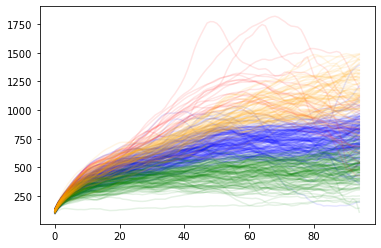

In [353]:
data = dp_TS.iloc[:,1:].to_numpy()
seed = 0
model = TimeSeriesKMeans(n_clusters=4, metric='euclidean', max_iter=10,random_state=seed).fit(data)
color = ['b', 'g', 'r','orange','c', 'purple', 'm', 'k','brown','olive','y']
for clus_num in range(4):
    for xx in data[model.labels_ == clus_num]:
        plt.plot(xx.ravel(), color = color[clus_num] , alpha=0.1)
plt.show()

In [352]:
var_name

'tmmn_mean'

## Data importing and cleaning

### Loading area of study and gauges coordinates

In [77]:
# Loading the map of colorado river basin with rivers
basin = gpd.read_file('Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shx',
                   bbox = (-119.92,-10124,30.35,44.08))
basin = basin.drop([0,1,2,3,4,5])
rivers = gpd.read_file('2ecafda8-df4e-48ea-beac-fd22238c26592020313-1-19nxhp4.a488.shx')


# Coordiantes of gauges
metadata_all = pd.read_csv('colorado_metadata_all.csv', encoding='windows-1252')
# Dropping unnecessary columns
metadata_all = metadata_all.drop(['HUC02', 'in_crb', 'full_years_in_1921',
            'full_years_in_1931', 'full_years_in_1941', 'full_years_in_1951',
            'full_years_in_1961', 'full_years_in_1971', 'full_years_in_1981',
            'full_years_in_1991', 'full_years_in_2001', 'full_years_in_2011',
            'lat_cent', 'long_cent'],
             axis=1)
metadata_all[['HCDN.2009']] = metadata_all[['HCDN.2009']].fillna('no')


# 30 sites of interset's SiteIDs
in_df = pd.read_excel('rdews_pilot_gages.xlsx')
long_ID_list = list(in_df['StaID'])

# 30 sites coordinates
coordinates_30 = metadata_all.loc[metadata_all['site'].isin(long_ID_list)]
coordinates_30 = coordinates_30.reset_index(drop=True)
# 425 sites coordinates
coordinates_425 = metadata_all
# Exclude gauges with drainage area greater that 100000 sqkm
coordinates_425 = coordinates_425[coordinates_425['DRAIN_SQKM']<=100000]
coordinates_425 = coordinates_425.reset_index(drop=True)

### Loading and cleaning data for 20% threshold

In [78]:
# Data for streamflow
Streamflow = pd.read_csv('streamflow_percentile_thresholds_1980-2020.csv')
# Specifying the threshold we want
# Here as a starting point we want thresh_20_jd_30d_wndw
threshold = 'thresh_20_jd_30d_wndw'
St_tseries = Streamflow[Streamflow['threshold'] == threshold]
# Drop unnecessary columns (axis=1)
St_tseries = St_tseries.drop(['threshold', 'thresh_type', 'thresh_level'],axis=1)
# reset indices
St_tseries = St_tseries.reset_index(drop=True)

# Slicing the 30 specified Sites from 425 gages
pilot_30 = St_tseries.loc[St_tseries['StaID'].isin(long_ID_list)]
pilot_30 = pilot_30.reset_index(drop=True)

### Loading the daily data for each gauge (site)

In [79]:
directory_30 = '../ProjectwithSOMTimeS/CRB_streamflow_data_30sites_2022-04-28/'
directory_425 = '../ProjectwithSOMTimeS/CRB_streamflow_data_425sites/'
input_sites30 = [file for file in os.listdir(directory_30)]
input_sites425 = [file for file in os.listdir(directory_425)]

### Loading and Cleaning event data

In [110]:
# Loading drought properties data
# weibull_jd_Drought_Properties
raw_jdp_data = pd.read_csv('weibull_jd_Drought_Properties.csv')

# weibull_site_Drought_Properties
raw_sdp_data = pd.read_csv('weibull_site_Drought_Properties.csv')

# Dropping unnessesary columns
raw_sdp_data.drop(raw_sdp_data.columns.difference(['drought_id',
                                                   'severity','duration','start','end','threshold','site']),
                  axis=1, inplace=True)

raw_jdp_data.drop(raw_jdp_data.columns.difference(['drought_id',
                                                   'severity','duration','start','end','threshold','site']),
                  axis=1, inplace=True)


# Specify the threshold
threshold = 20
sdp_data_clean = raw_sdp_data[raw_sdp_data["threshold"] == threshold]
jdp_data_clean = raw_jdp_data[raw_jdp_data["threshold"] == threshold]
# delet drought event that we do not have daily data for (before 1981-10-01)

# Renaming the data and reseting the indces
sdp_data = sdp_data_clean.reset_index(drop=True)
jdp_data = jdp_data_clean.reset_index(drop=True)


# Code Starts here

## Define parameters

In [111]:
# Specifying the method
feature = 'jdp'
# bin width equal to 1 so we can have a value for each day
bin_width = 1

## Timeseries calculation for 425 sites

### Annual streamflow 20% threshold

C:\Users\adadkhah\.conda\envs\geostats\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


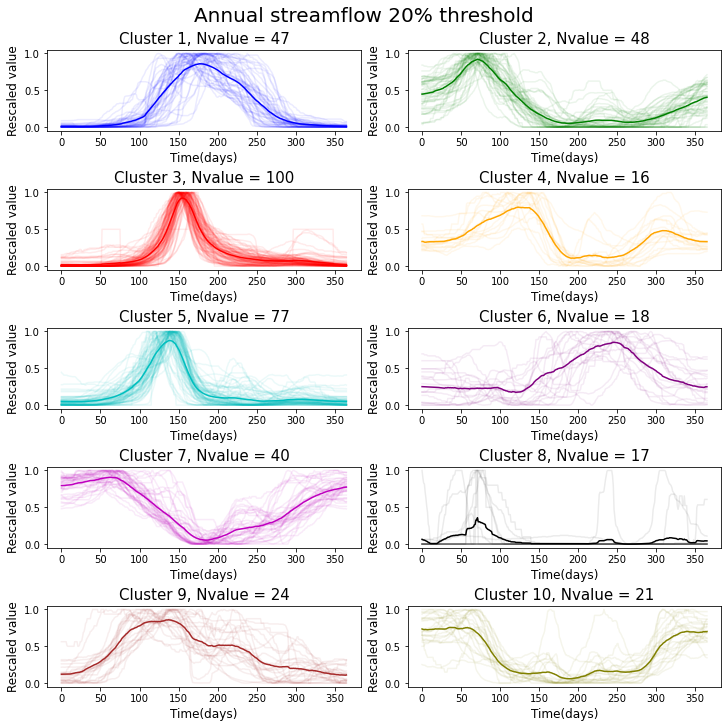

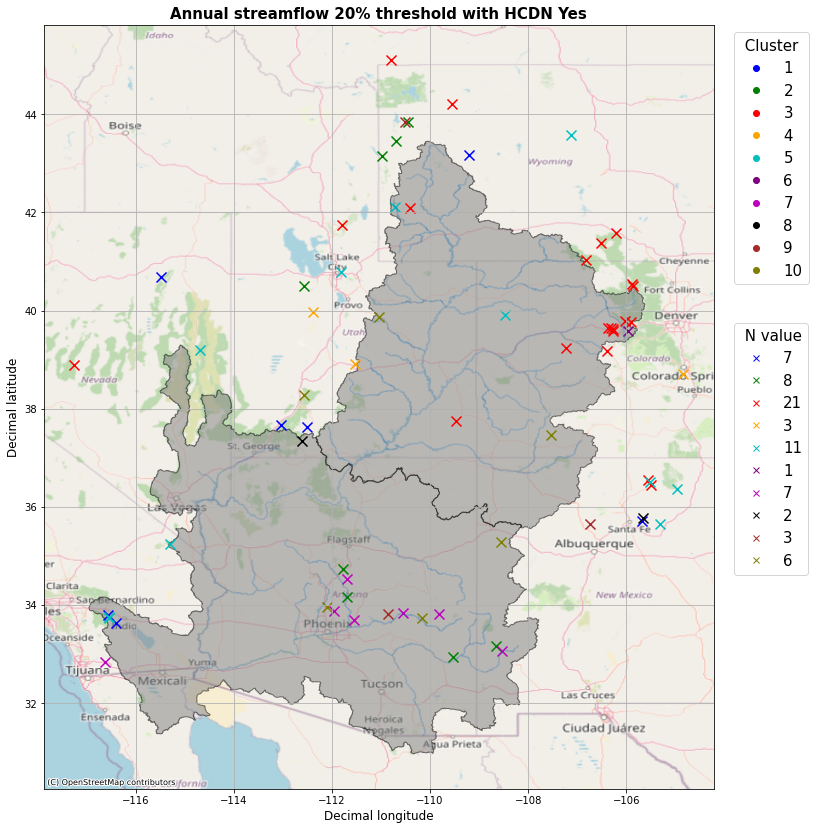

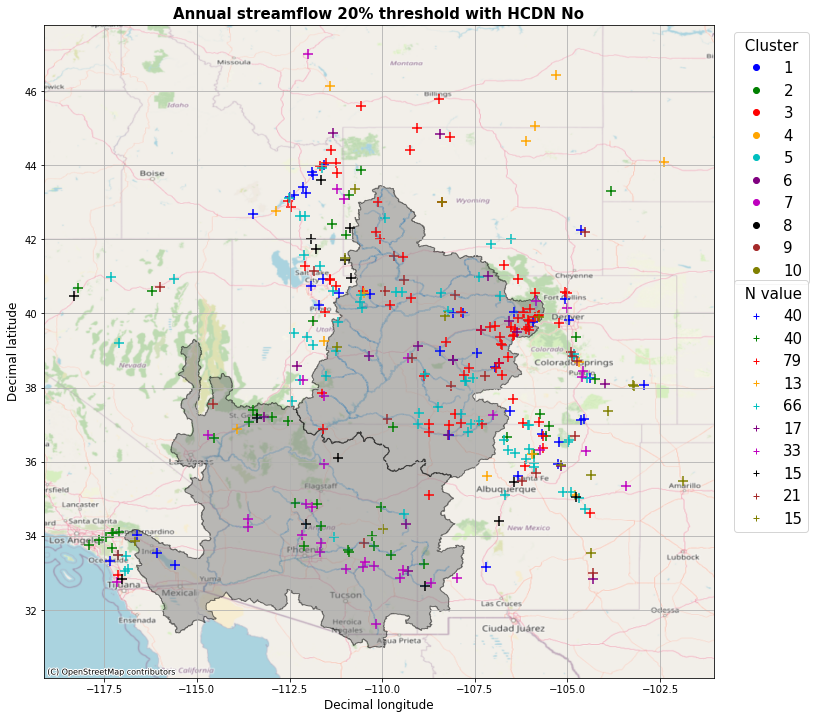

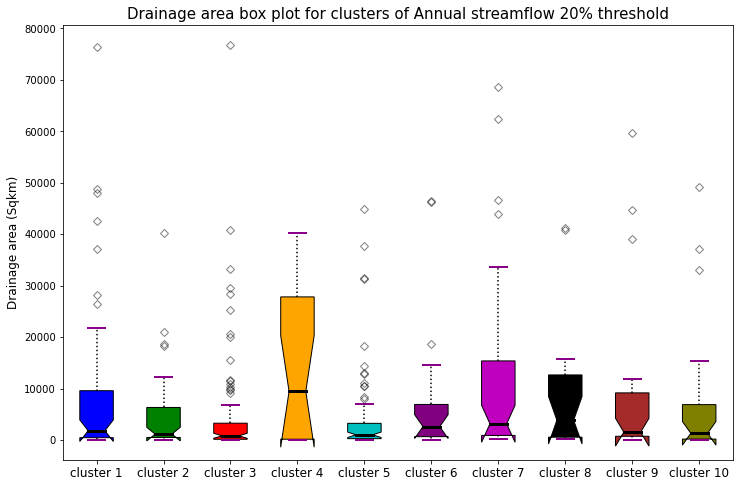

In [341]:
Annual_Streamflow_threshold20 = St_tseries
var_name = 'thresh_20_jd_30d_wndw'
geo_temp = TScluster(Annual_Streamflow_threshold20,10,'euclidean',coordinates_425,var_name)
clusterplot(geo_temp,var_name)
bxplt(geo_temp,var_name)

### Min daily temperature semivariograms

In [345]:
var_name = 'tmmn_mean'
tmmn_TS = Sv_df(var_name,directory_425,95)

C:\Users\adadkhah\.conda\envs\geostats\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


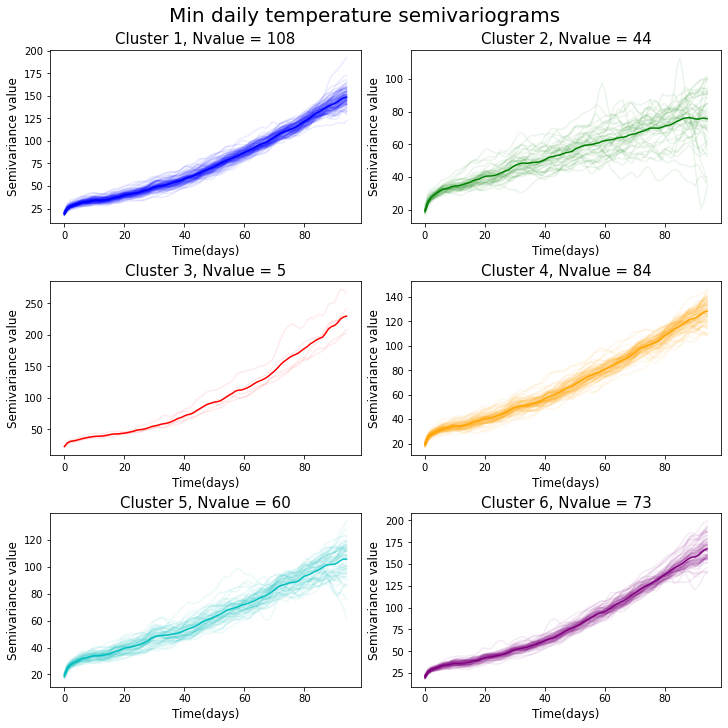

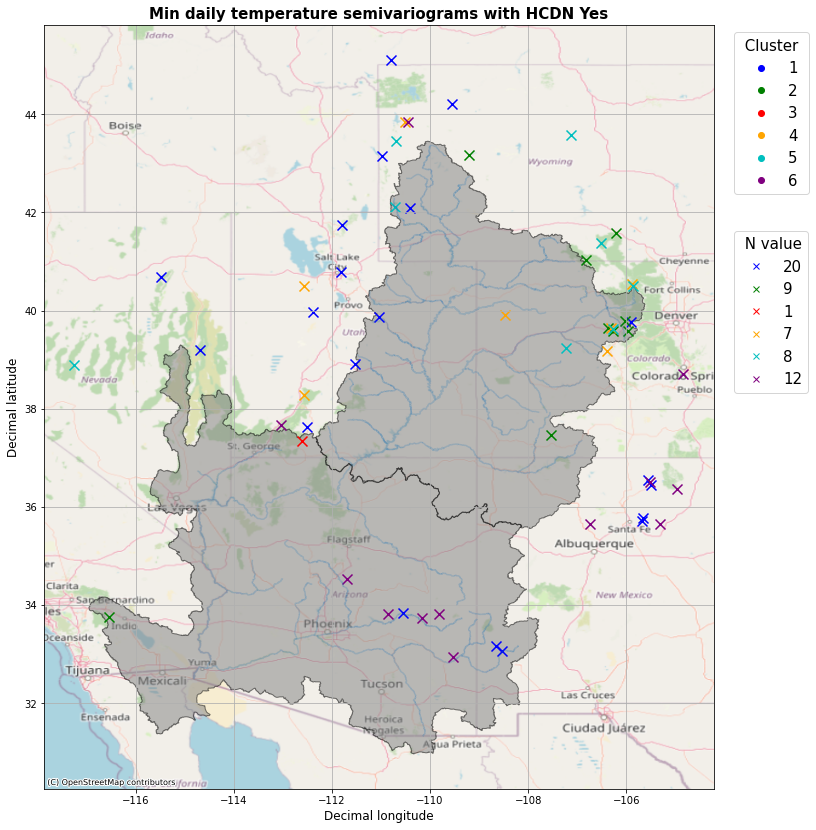

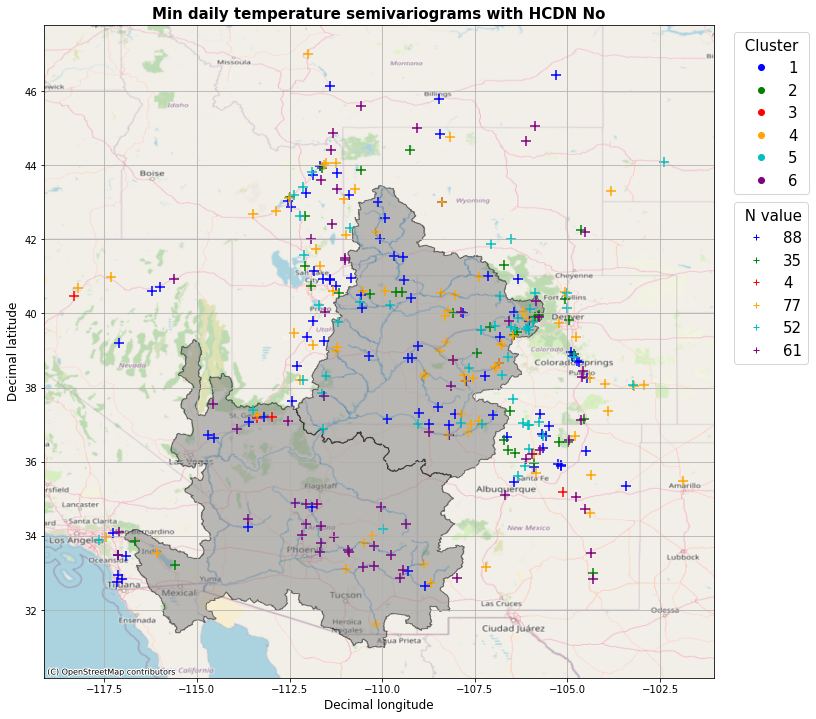

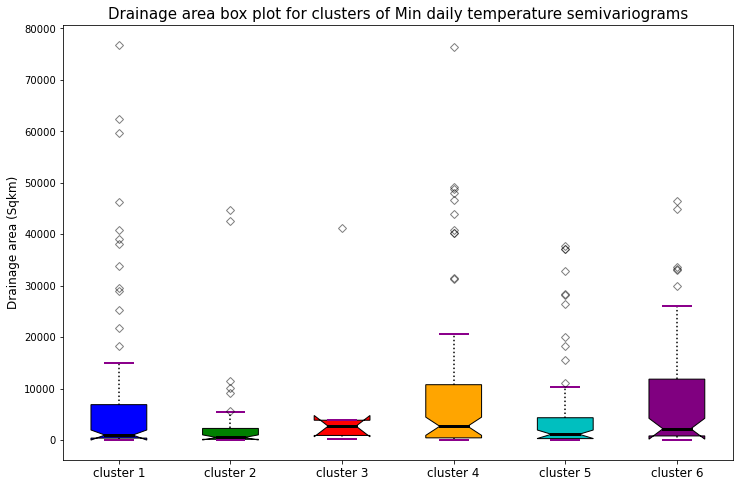

In [344]:
var_name = 'tmmn_mean'
geo_temp = TScluster(tmmn_TS,6,'euclidean',coordinates_425,var_name)
clusterplot(geo_temp,var_name)
bxplt(geo_temp,var_name)

### Daily precipitation semivariograms

In [314]:
var_name = 'pr_mean'
pr_TS = Sv_df(var_name,directory_425,95)

C:\Users\adadkhah\.conda\envs\geostats\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


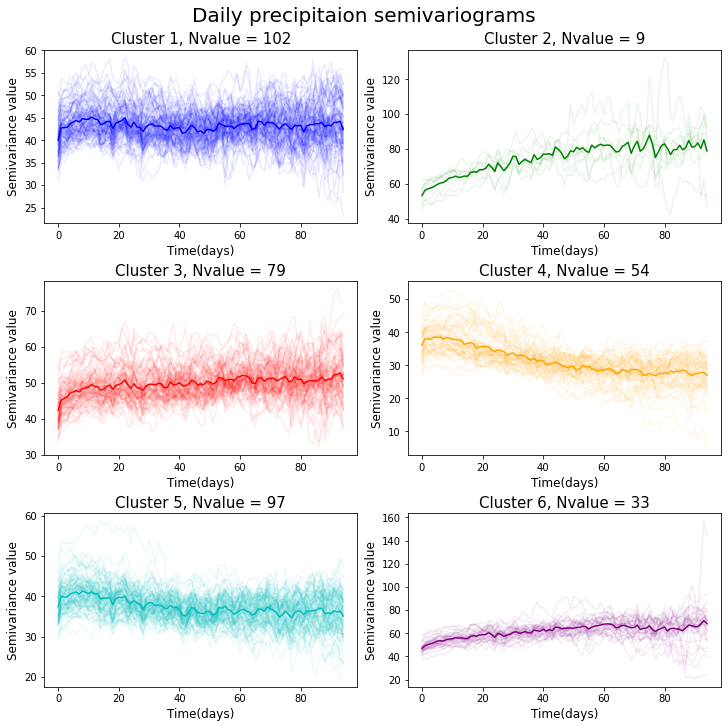

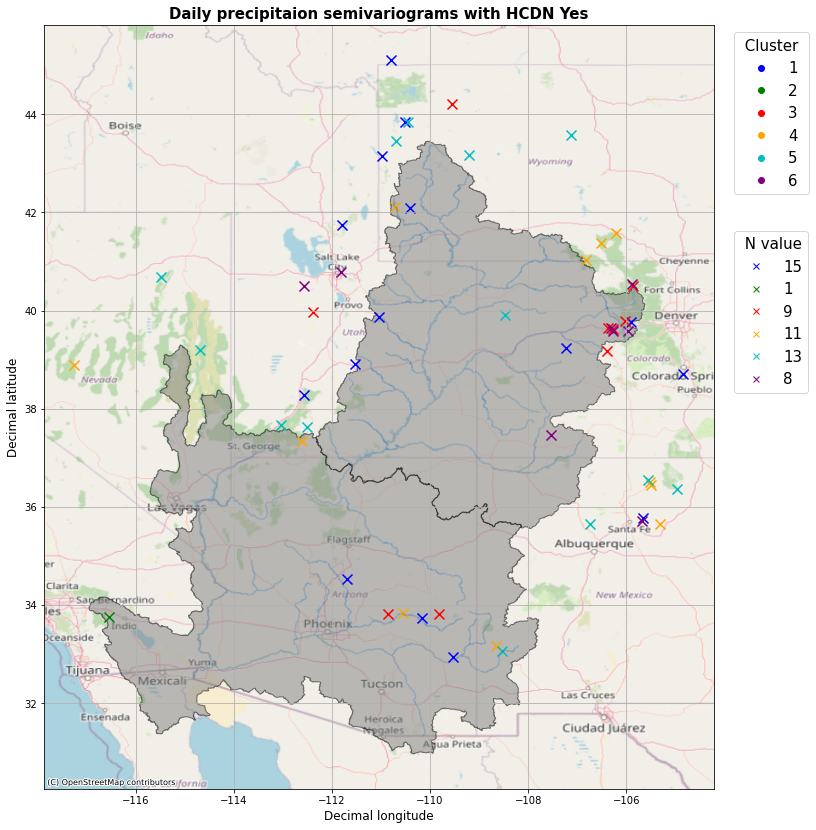

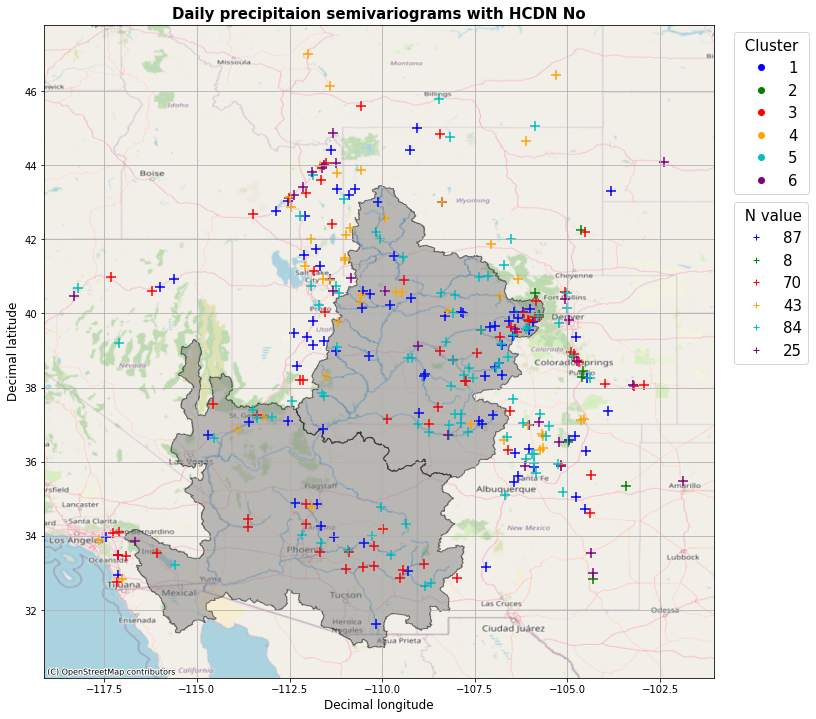

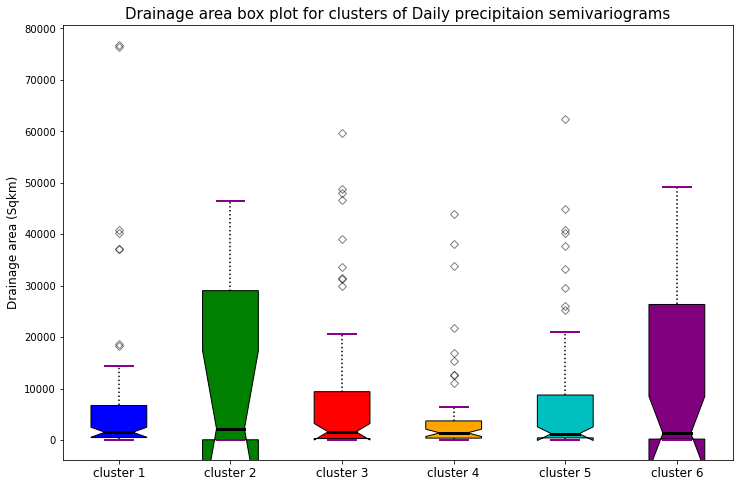

In [321]:
var_name = 'pr_mean'
geo_temp = TScluster(pr_TS,6,'euclidean',coordinates_425,var_name)
clusterplot(geo_temp,var_name)
bxplt(geo_temp,var_name)

### Medium depth (10-40cm) soil moisture semivariograms

In [323]:
var_name = 'SoilM_10_40cm_mean'
sm_TS = Sv_df(var_name,directory_425,95)

C:\Users\adadkhah\.conda\envs\geostats\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


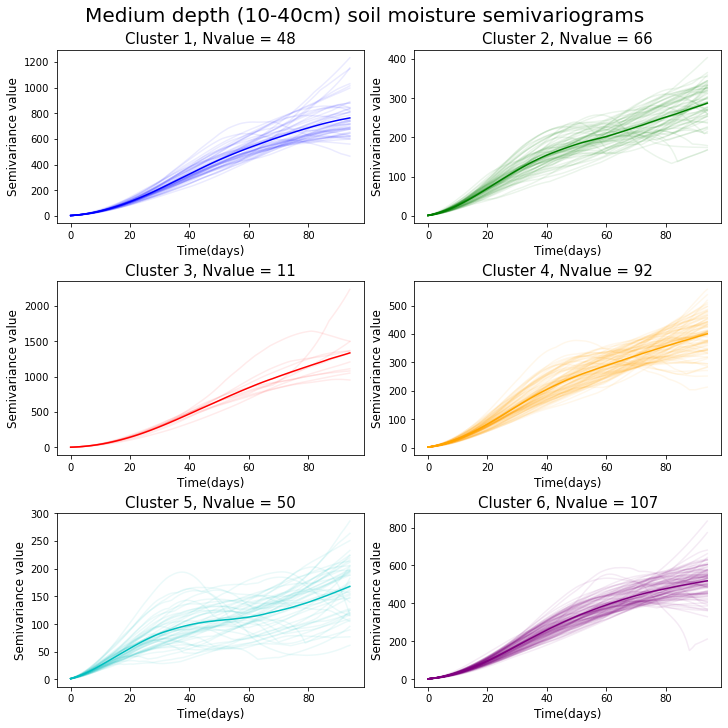

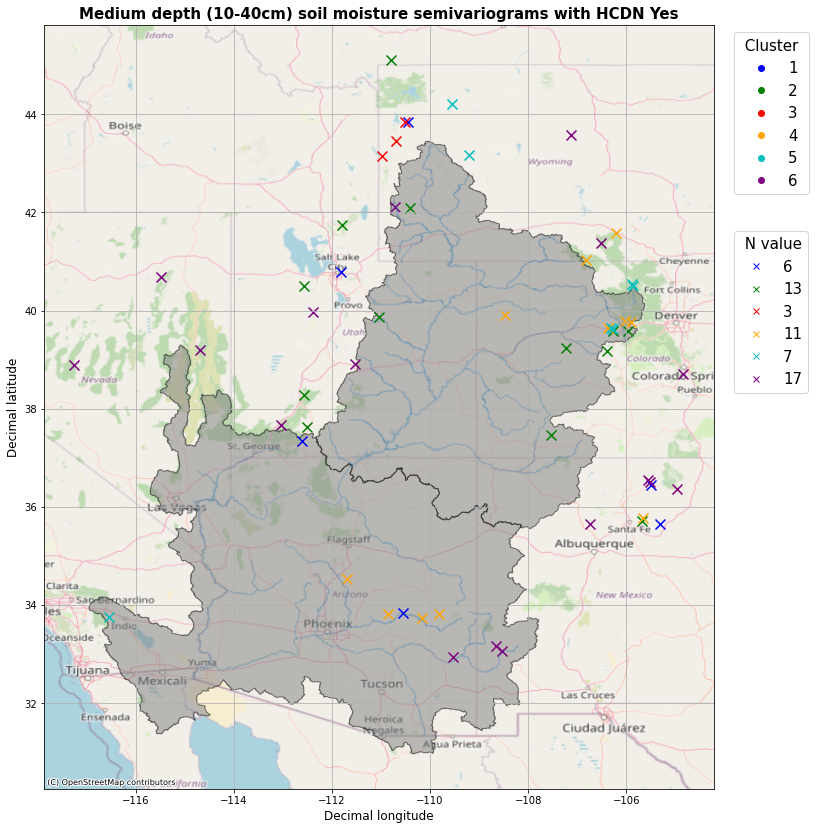

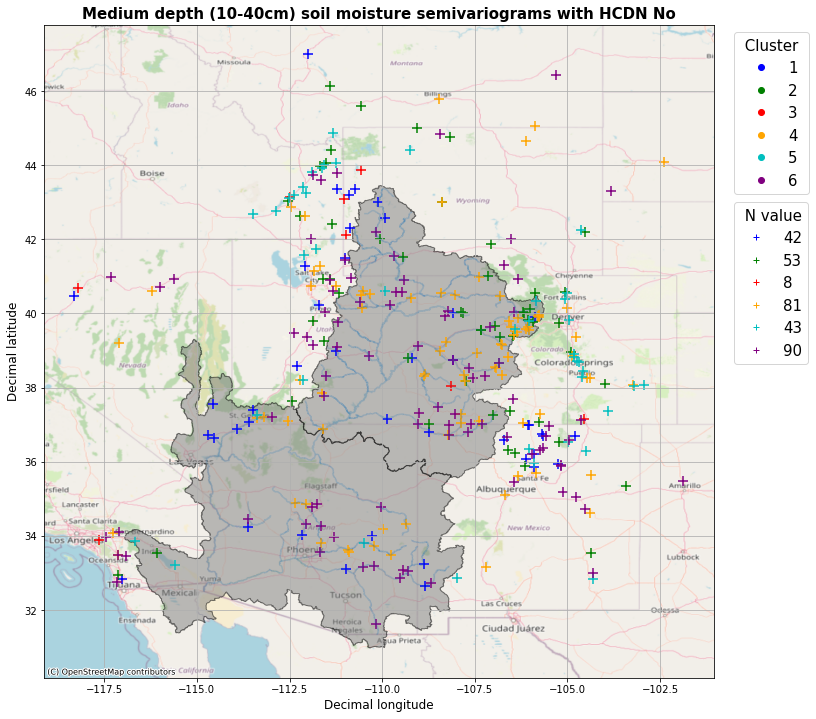

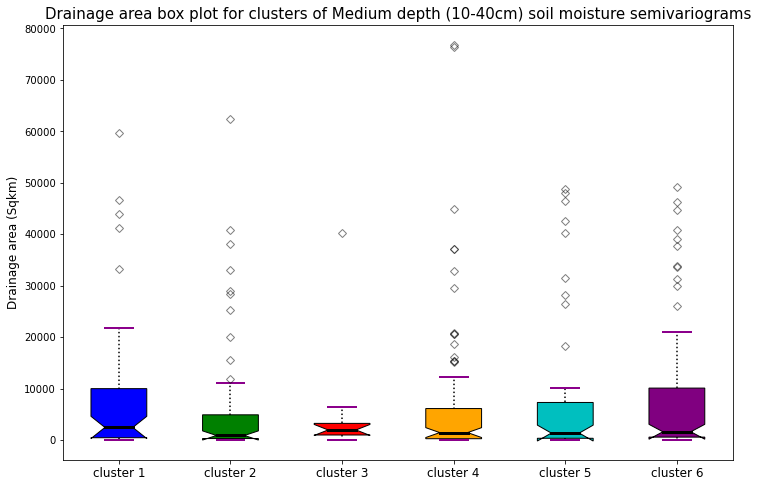

In [355]:
var_name = 'SoilM_10_40cm_mean'
geo_temp = TScluster(sm_TS,6,'euclidean',coordinates_425,var_name)
clusterplot(geo_temp,var_name)
bxplt(geo_temp,var_name)

### Snow water equivalent (SWE) semivariograms

In [322]:
var_name = 'SWE_mean'
swe_TS = Sv_df(var_name,directory_425,95)

C:\Users\adadkhah\.conda\envs\geostats\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


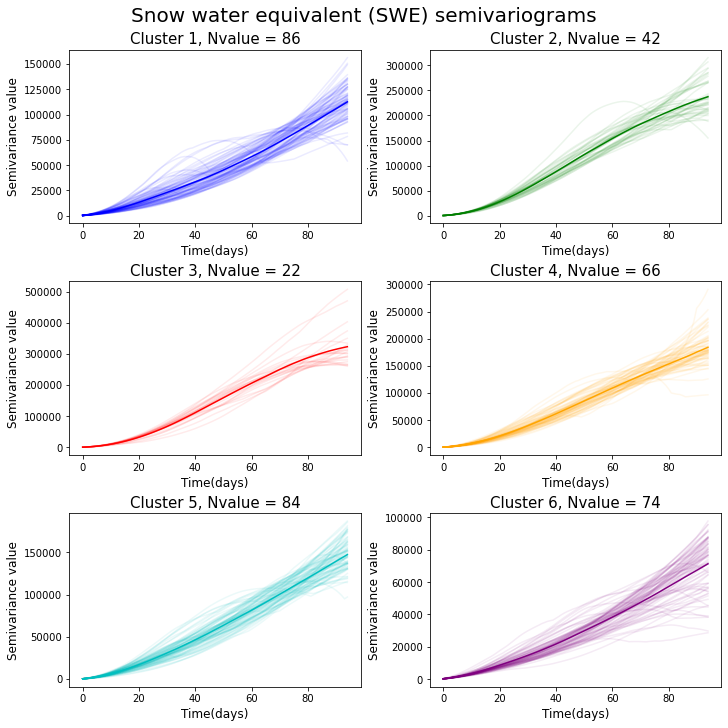

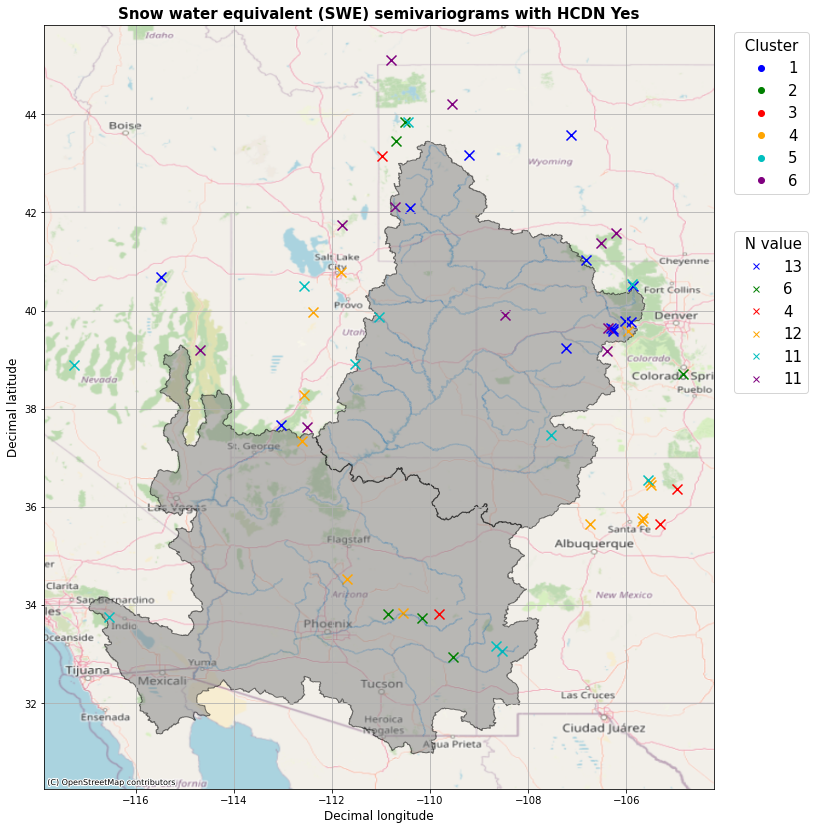

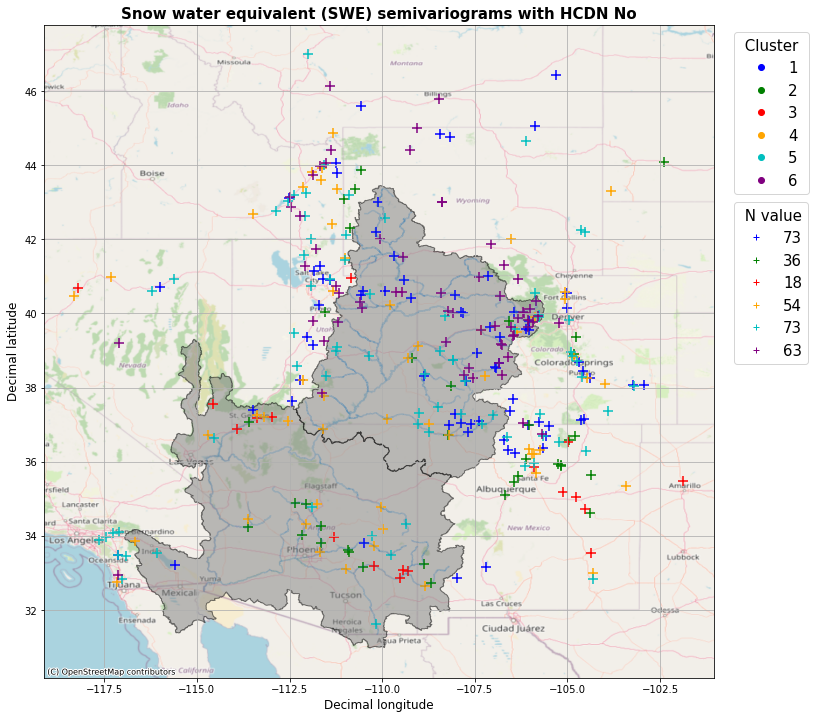

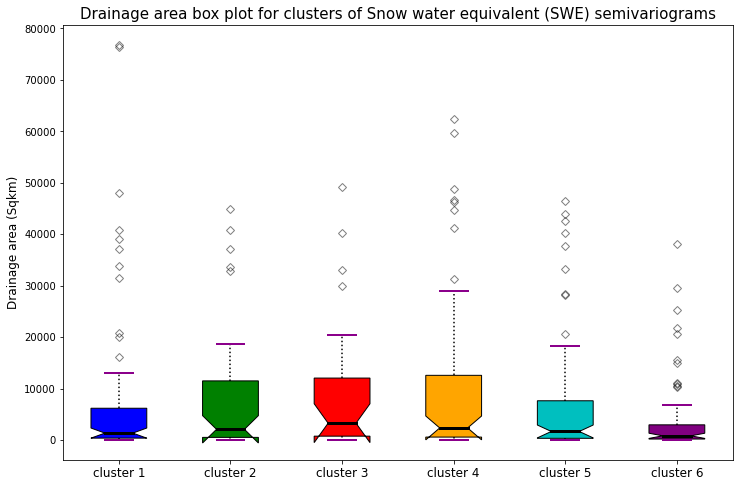

In [356]:
var_name = 'SWE_mean'
geo_temp = TScluster(swe_TS,6,'euclidean',coordinates_425,var_name)
clusterplot(geo_temp,var_name)
bxplt(geo_temp,var_name)

### Daily percentile semivariogram

In [324]:
var_name = 'weibull_jd_30d_wndw'
dp_TS = Sv_df(var_name,directory_425,95)

C:\Users\adadkhah\.conda\envs\geostats\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


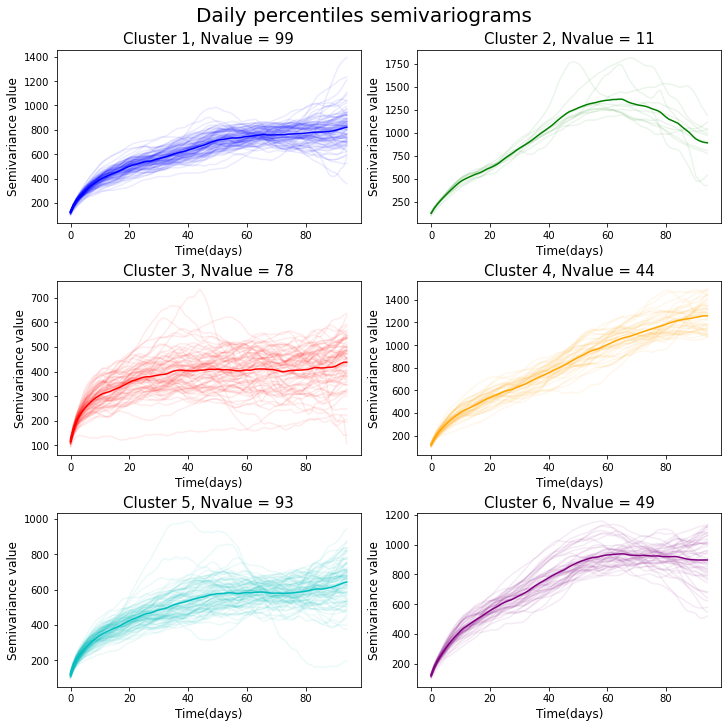

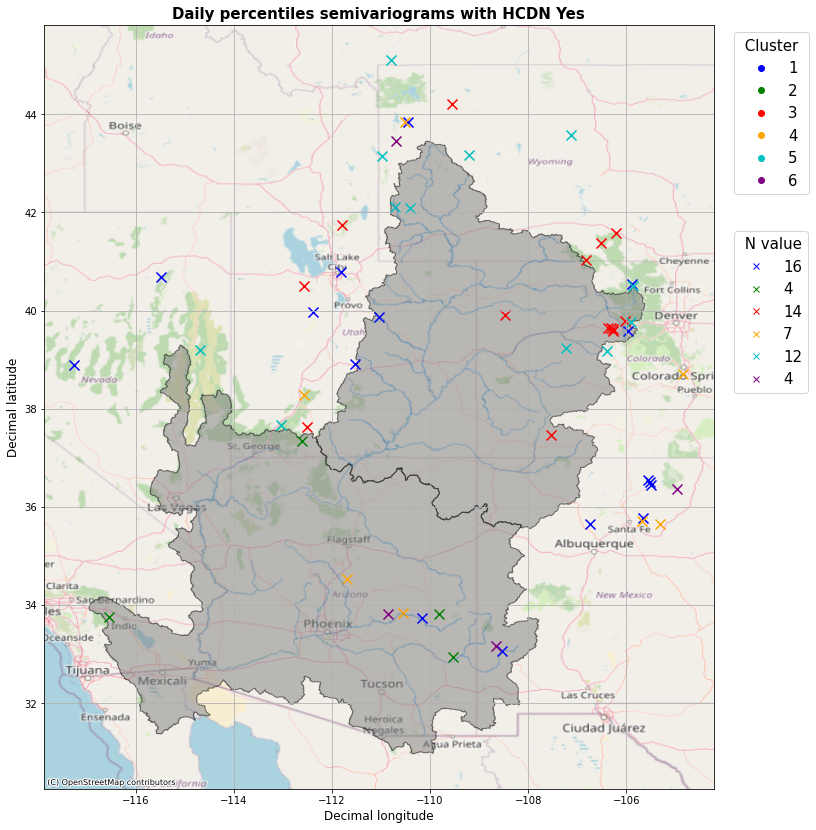

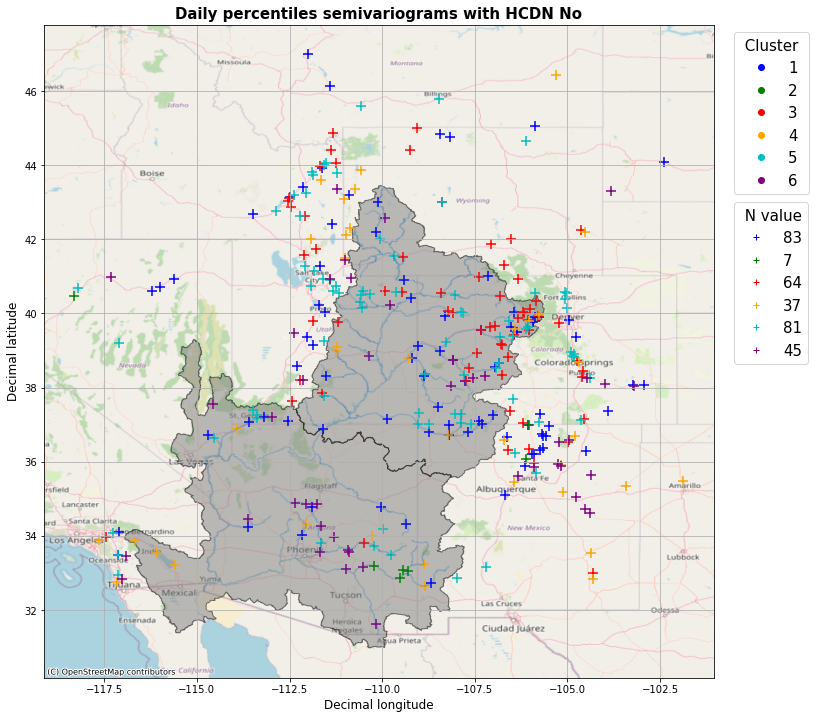

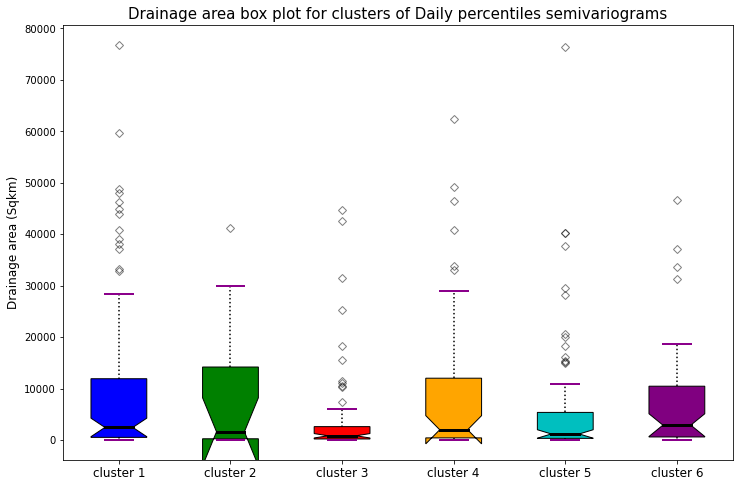

In [354]:
var_name = 'weibull_jd_30d_wndw'
geo_temp = TScluster(dp_TS,6,'euclidean',coordinates_425,var_name)
clusterplot(geo_temp,var_name)
bxplt(geo_temp,var_name)